In [1]:
# increases cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# import python modules
from matplotlib import pyplot as plt
import numpy

# makes pyplot figures interactive
%matplotlib notebook

# makes sure imported modules are updated when the files change
%load_ext autoreload
%autoreload 2

In [2]:
def plot_state(x, ax, *args, **kwargs):
    ax.plot(
        numpy.array(x)[:, 0], 
        numpy.array(x)[:, 1], 
        *args, **kwargs
    )
    
def plot_error(x, y, ax, *args, **kwargs):
    ax.plot(
        numpy.linalg.norm(numpy.array(x)[:, :2]-numpy.array(y)[:, :2], axis=1), 
        *args, **kwargs
    )

# The Kalman filter

A common problem in many areas of science and engineering is to estimate the state $\vec s_t$ of a system based on incomplete measurements $\vec z_0,\ldots , \vec z_t$ from previous time-steps. The measurements are often coming from multiple sensors that measure different parts of the state and have different noise levels. Some times control-inputs $\vec u_0,\ldots,\vec u_{t-1}$ are also available. 

The Kalman filter is a method for fusing all this information in an optimal* way. 

## Kalman Filter assumptions

As with any optimal algorithm, the inputs to a Kalman filter need to satisfy some fairly strong assumptions for all the formal guarantees to hold (hence the asterisk above). Luckily it's often often possible to get "close enough" to these assumptions by clever pre-processing and outlier rejection. Concretely, the Kalman filter assumes:

#### Linear motion model
The state $\vec s_t$ evolves according to a linear dynamical system with gaussian noise $\vec r_t \sim N(0,I)$ and (known) control input $\vec u_t$:

* $\vec s_{t+1} = A\vec s_t + B\vec u_t + Q\vec r_t$

#### Linear measurement model
Each measurement is a linear transformation of the true state corrupted by gaussian noise $\vec w_t \sim N(0,I)$:

* $\vec z_{t} = H\vec s_t + T\vec w_t$

Note that this means we need to estimate the matrices $A, B, Q, H$ and $T$ to implement the filter. This is a difficult problem in itself but even if no accurate estimates are available it's often still possible to make an educated guess based on the overall structure of the system model and tune the values manually until the estimates are good enough for whatever problem you are trying to solve. There are also many methods for estimating these parameters dynamically or by controlled experiments (e.g. state space identification methods).


## GPS + odometry fusion example

Here's a demonstration on how to implement a simple Kalman filter for localizing a car based on GPS and wheel odometry. We model the state $\vec s_t$ of the car by its 2D position $\vec x_t$ position and velocity $\vec v_t$ in GPS coordinates: 

* $\vec s_t = \begin{pmatrix} \vec x_t \\ \vec v_t\end{pmatrix}$

#### motion model
At each time step the motion of the car is dictated by its current velocity. We get the next position by adding the velocity multiplied by the time-step $\Delta t$: 

* $\vec x_{t+1} = \vec x_t + \Delta t\vec v_t$

and that the velocity is set by the direction and rotation rate of the wheels (represented as $u_t$):

* $\vec v_{t+1} = \vec u_t$

This motion model is of course not very realistic for a car in general, the driver can't freely pick any velocity at every timestep! However, if we assume that the timestep is long enough that velocity control can be abstracted out and we limit our experiments to slowly varying control inputs we should still be able to get some insight on how a real system would behave.

#### measurement model
The absolute position of the car is measured by the GPS at every time step with noise level $\sigma_{\text{gps}}$:
* $\vec z_{t} = \vec x_t + \sigma_{\text{gps}}\vec w_t$

Since we only have indirect control of the wheels through the steering wheel and gas/break pedals we can only make an estimate $\tilde u_t$ of the true control $\vec u_t$ with uncertainty level $\sigma_{\text{odom}}$: 
* $\tilde u_t = \vec u_t + \sigma_{\text{odom}}\vec r_t$

In [3]:
# Motion model matrices
A = numpy.array([
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

B = numpy.array([
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1]
])

odometry_stddev = 0.1
Q = numpy.array([
    [odometry_stddev, 0],
    [0, odometry_stddev]
])
r_dim = Q.shape[1]

# Observation model matrices
H = numpy.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

gps_stddev = 0.6
T = numpy.array([
    [gps_stddev, 0],
    [0, gps_stddev],
])
w_dim = T.shape[1]

def motion_model(x, u):
    return A.dot(x) + B.dot(u)

## Kalman filter  equations

At each new timestep $t+1$ we **predict** the next state based on a previous estimate by applying the motion model to the previous state estimate: $\hat s_{t+1}' = A\hat s_t + B\vec u_t$. We then then apply the measurement model to this prediction and check how well it matches with the corresponding measurement. The difference between the two is called the **measurement residual** or **innovation term**: $\vec y_t = \vec z_{t+1} - H\hat s_{t+1}'$. 

In broad strokes the Kalman filter uses linear feedback of the measurement residual to control the state estimate in such a way that it results in the smallest possible estimation error over time at the given noise level (in $L2$ norm). In order to know which feedback (or **kalman gain**) to apply to the measurement residual it also keeps a rolling estimate $\hat P_t$ of the true state covariance $P_t = \mathbb{E}[\vec s_t \vec s_t^T]$.

#### One Kalman filter iteration

The steps that makes up one iteration of the Kalman filter are as follows:

* Predict the next state and covariance based on the motion model: 
    * $\hat s_{t+1}' = A\hat s_t + B\vec u_t$
    * $\hat P_{t+1}' = A\hat P_{t}A^T + QQ^T$

* Compute Kalman gain:
    * $K_t = P_{t+1}'H^T(HP_{t+1}'H^T + TT^T)^{-1}$

* Measure $\vec z_{t} = H\vec s_t + T\vec w_t$ and compute measurement-prediction residual:
    * $\vec y_t = \vec z_t - H\hat s_{t+1}'$

* Update state and covariance estimates:
    * $\hat s_{t+1} = \hat s_{t+1}' + K_t\vec y_t$
    * $\hat P_{t+1} = (I - K_tH)\hat P'_{t+1}$

See for example http://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf or https://arxiv.org/pdf/1910.03558.pdf for a derivation.

For the car example a slight modification of the regular setup is required to accommodate for the unknown control input (see if you can spot the differences in the implementation below!)

# Experiments! 

<IPython.core.display.Javascript object>


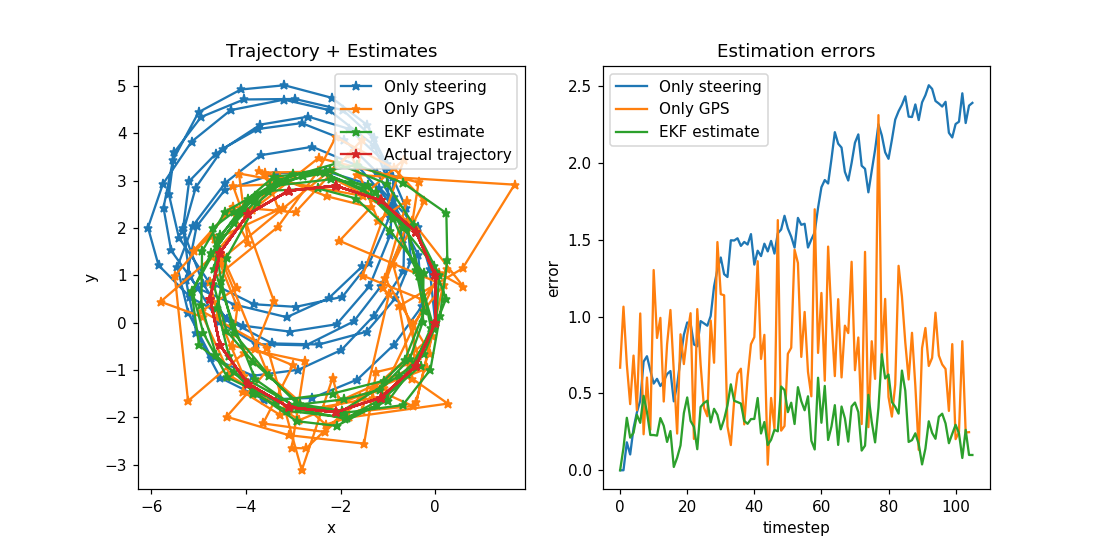

In [4]:
fig, (ax_trajectory, ax_error) = plt.subplots(1, 2, figsize=(10, 5))

x_odom = [numpy.array([0, 0, 0, 0])]
x_gt = [numpy.array([0, 0, 0, 0])]
x_ekf = [numpy.array([0, 0, 0, 0])]
z = []
P = numpy.eye(4) * 0.1

time_step = 0

Run the below block multiple times to advance the simulation `N` time steps (increase `N` to speed things up). 

Notice how the GPS signal is noisy and unreliable in the short term but stable in the long term, while the odometry is accurate in the short term but drifts away from the true position in the long term. The EKF provides an optimal tradeoff between the two options.

Try tweaking the model parameters (e.g. `odometry_stddev` or `gps_stddev`) and check if the trajectory and error signals behave as you'd expect!

In [25]:
N = 5
circle_period = 15
for n in range(time_step, time_step+N):
    
    # control signal
    u = numpy.array([
        -numpy.sin(n / circle_period * 2 * numpy.pi), 
        numpy.cos(n / circle_period * 2 * numpy.pi)
    ])
    u_noisy = u + Q.dot(numpy.random.randn(r_dim))
    
    # Noise-free state (ground truth)
    x_gt.append(motion_model(x_gt[-1], u))
    
    # Noisy odometry
    x_odom.append(motion_model(x_odom[-1], u_noisy))
    
    # EKF prediction step
    x_predict = motion_model(x_ekf[-1], u_noisy)
    P_predict = A.dot(P).dot(A.T) + B.dot(Q.dot(Q.T) *10 ).dot(B.T)
    
    # EKF update step
    S = H.dot(P).dot(H.T) + T.dot(T.T)
    K = P.dot(H.T).dot(numpy.linalg.inv(S))
    
    z.append(H.dot(x_gt[-1]) + T.dot(numpy.random.randn(w_dim)))
    x_ekf.append(x_predict + K.dot(z[-1] - H.dot(x_predict)))

time_step += N

ax_trajectory.clear()
plot_state(x_odom, ax_trajectory, '*-', label='Only steering')
plot_state(z, ax_trajectory, '*-', label='Only GPS')
plot_state(x_ekf, ax_trajectory, '*-', label='EKF estimate')
plot_state(x_gt, ax_trajectory, '*-', label='Actual trajectory')
ax_trajectory.legend()
ax_trajectory.axis('equal')
ax_trajectory.set_title('Trajectory + Estimates')
ax_trajectory.set_xlabel('x')
ax_trajectory.set_ylabel('y')

ax_error.clear()
plot_error(x_odom, x_gt, ax_error, label='Only steering')
plot_error(z, x_gt[1:], ax_error, label='Only GPS')
plot_error(x_ekf, x_gt, ax_error, label='EKF estimate')
ax_error.set_title('Estimation errors')
ax_error.set_xlabel('timestep')
ax_error.set_ylabel('error')
ax_error.legend()